## Loading Dataset

In [1]:
import os
import glob
import shutil

dataset_dir = os.path.expanduser("D:\\GIKI\\GEN AI\\Assignment 3\\UCF101\\UCF-101")

#organizing video data
folder_dir = os.path.join(dataset_dir, "vid_data")
os.makedirs(folder_dir, exist_ok=True)

# Move all video files and subdirectories (except vid_data) to 'vid_data' directory
my_path = dataset_dir
files = glob.glob(os.path.join(my_path, "*"), recursive=False)

for vidfolder in files:
    if os.path.basename(vidfolder) != "vid_data":
        destination_path = os.path.join(folder_dir, os.path.basename(vidfolder))
        shutil.move(vidfolder, destination_path)



I worked on just one of the classes from the dataset due to computational limitations.

# Exctracting images from video frame

In [2]:
import os
import subprocess
import glob

dataset_dir = "D:\\GIKI\\GEN AI\\Assignment 3\\UCF101\\UCF-101"
vid_data_dir = os.path.join(dataset_dir, "vid_data")
img_data_dir = os.path.join(dataset_dir, "img_data")
os.makedirs(img_data_dir, exist_ok=True)

# Locate only one  .avi video folders to process due to computational limitation
video_classes = glob.glob(os.path.join(vid_data_dir, "*/"))[:1]

for VidClass in video_classes:
    video_files = glob.glob(os.path.join(VidClass, "*.avi"))
    for vidItem in video_files:
        path = os.path.splitext(vidItem)[0]
        store_pth = path.replace("vid_data", "img_data")
        if not os.path.exists(store_pth):
            os.makedirs(store_pth)

        vidItem = os.path.abspath(vidItem).replace("\\", "/")
        store_pth = os.path.abspath(store_pth).replace("\\", "/")



        query = f"ffmpeg -i \"{vidItem}\" -r 20 \"{store_pth}/pic%04d.jpg\" -hide_banner"
        response = subprocess.Popen(query, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        stdout, stderr = response.communicate()





# Loading and preprocess image sequences

Dataset length: 458


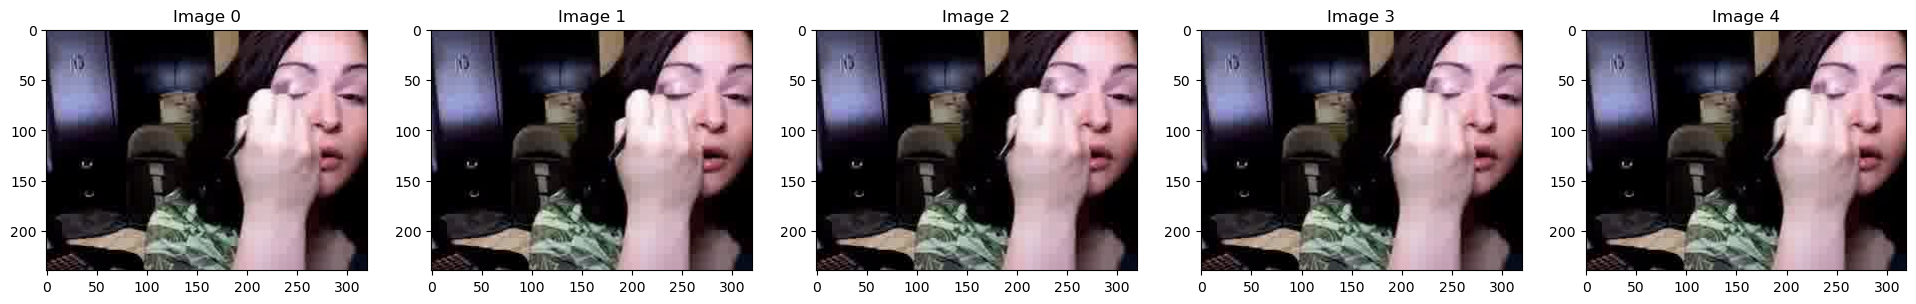

In [3]:
import torch
from torch.utils.data import Dataset

import cv2
import numpy as np
import matplotlib.pyplot as plt

import glob
import os

data_path = "D:/GIKI/GEN AI/Assignment 3/UCF101/UCF-101/img_data"

class UCF(Dataset):
    def __init__(self, flag, subset_ratio=0.03):  # ratio dataset
        super(UCF, self).__init__()
        self.dataset = self.get_image_paths()
        subset_length = int(len(self.dataset) * subset_ratio)

        if flag == 'train':
            self.data = self.dataset[0:int(0.8 * subset_length)]
        elif flag == 'test':
            self.data = self.dataset[int(0.8 * subset_length):subset_length]
        else:
            print('Could not load the dataset')

    def get_image_paths(self):  #contain images according to the ratio set
        data_frames = []
        for root, _, f_names in os.walk(data_path):
            video = [os.path.join(root, f) for f in f_names if f.endswith(".jpg")]
            if len(video) > 0:
                video.sort()
                i, j = 0, 5
                while j < len(video):
                    data_frames.append(video[i:j])
                    i += 1
                    j += 1
        return data_frames


    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        images = self.data[index]
        for i, image in enumerate(images):
            data = cv2.imread(image, cv2.IMREAD_COLOR)
            data = cv2.cvtColor(data, cv2.COLOR_BGR2RGB)
            data = data.transpose(2, 0, 1)
            data = (data / 127.5) - 1
            data = np.float32(data)
            data = torch.tensor(data)
            if i == 0:
                data_frames = data
            else:
                data_frames = np.concatenate((data_frames, data), axis=0)

        data_frames = torch.tensor(data_frames)
        return data_frames

if __name__ == "__main__":
    test_dataset = UCF(flag='train')
    print(f"Dataset length: {len(test_dataset)}")
    sample = test_dataset[20]
    sample = sample.numpy()
    cols = 5
    figure, ax = plt.subplots(nrows=1, ncols=cols, figsize=(24, 6))
    for col in range(cols):
        image = sample[col * 3:(col * 3) + 3, :, :]
        image = image.transpose(1, 2, 0)
        image = (image + 1) * 127.5
        image = image.astype('uint8')
        ax[col].imshow(image)
        ax[col].set_title(f'Image {col}')
    plt.show()


# Model

In [4]:
import torch
import torch.nn as nn
from torchsummary import summary

def weights_init(m):
    if isinstance(m, nn.Conv3d) or isinstance(m, nn.ConvTranspose3d):
      nn.init.normal_(m.weight.data, 0, 0.02)
      # nn.init.constant_(m.bias.data,0)

class DownConv(nn.Module):
  def __init__(self,in_channels,out_channels,kernel,stride, activation='relu'):
    super(DownConv,self).__init__()

    self.activation = {
        'relu': nn.ReLU(),
        'leakyRelu': nn.LeakyReLU(0.2)
    }
    self.layers = nn.Sequential(
        nn.Conv2d(in_channels = in_channels, out_channels=out_channels, kernel_size=kernel, stride=stride, padding=1),
        nn.InstanceNorm2d(out_channels),
        self.activation[activation],
    )
    self.apply(weights_init)
  def forward(self,x):
    x = self.layers(x)
    return x

class Residual_block(nn.Module):
  def __init__(self, in_channels, out_channels, kernel, stride, padding):
    super(Residual_block,self).__init__()
    self.block = nn.Sequential(
        nn.Conv2d(in_channels = in_channels, out_channels=out_channels, kernel_size=kernel, stride=stride, padding=padding),
        nn.InstanceNorm2d(out_channels),
        nn.ReLU(),
        nn.Conv2d(in_channels = out_channels, out_channels=out_channels, kernel_size=kernel, stride=stride, padding=padding),
        nn.InstanceNorm2d(out_channels),
    )
    self.apply(weights_init)
  def forward(self,x):
    identity = x
    out = self.block(x)
    out = torch.add(out, identity)
    return out

class UpConv(nn.Module):
  def __init__(self,in_channels, out_channels, kernel, stride):
    super(UpConv,self).__init__()
    self.layers = nn.Sequential(
        nn.ConvTranspose2d(in_channels,out_channels,kernel_size=kernel, stride=stride, padding=1, output_padding=1),
        nn.InstanceNorm2d(out_channels),
        nn.ReLU(),
    )
    self.apply(weights_init)
  def forward(self,x):
    x = self.layers(x)
    return x

class Generator(nn.Module):
  def __init__(self, in_channels):
    super(Generator,self).__init__()

    self.downconv1 = nn.Conv2d(in_channels=in_channels, out_channels=128, kernel_size=7, stride=1, padding='same')
    self.downconv2 = DownConv(in_channels=128, out_channels=128, kernel=3, stride=2, activation='relu')
    self.downconv3 = DownConv(in_channels=128, out_channels=256, kernel=3, stride=2, activation='relu')

    self.residual_block1 = Residual_block(in_channels=256, out_channels=256, kernel=3, stride=1, padding=1)
    self.residual_block2 = Residual_block(in_channels=256, out_channels=256, kernel=3, stride=1, padding=1)
    self.residual_block3 = Residual_block(in_channels=256, out_channels=256, kernel=3, stride=1, padding=1)
    self.residual_block4 = Residual_block(in_channels=256, out_channels=256, kernel=3, stride=1, padding=1)
    self.residual_block5 = Residual_block(in_channels=256, out_channels=256, kernel=3, stride=1, padding=1)
    self.residual_block6 = Residual_block(in_channels=256, out_channels=256, kernel=3, stride=1, padding=1)
    self.residual_block7 = Residual_block(in_channels=256, out_channels=256, kernel=3, stride=1, padding=1)
    self.residual_block8 = Residual_block(in_channels=256, out_channels=256, kernel=3, stride=1, padding=1)
    self.residual_block9 = Residual_block(in_channels=256, out_channels=256, kernel=3, stride=1, padding=1)

    self.upconv1 = UpConv(in_channels=256, out_channels=128, kernel=3, stride=2)
    self.upconv2 = UpConv(in_channels=128, out_channels=256, kernel=3, stride=2)
    self.downconv4 = nn.Conv2d(in_channels=256, out_channels=3, kernel_size=7, stride=1, padding='same')
    self.tanh = nn.Tanh()
    self.apply(weights_init)
  def forward(self,x):

    x = self.downconv1(x)
    x = self.downconv2(x)
    x = self.downconv3(x)

    x = self.residual_block1(x)
    x = self.residual_block2(x)
    x = self.residual_block3(x)
    x = self.residual_block4(x)
    x = self.residual_block5(x)
    x = self.residual_block6(x)
    x = self.residual_block7(x)
    x = self.residual_block8(x)
    x = self.residual_block9(x)

    x = self.upconv1(x)
    x = self.upconv2(x)
    x = self.downconv4(x)
    x = self.tanh(x)

    return x

class Discriminator(nn.Module):

  def __init__(self, in_channels):
    super(Discriminator,self).__init__()

    self.downconv1 = nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=4, stride=2, padding=1)
    self.activation = nn.LeakyReLU(0.2)
    self.downconv2 = DownConv(in_channels=64, out_channels=128, kernel=4, stride=2, activation='leakyRelu')
    self.downconv3 = DownConv(in_channels=128, out_channels=256, kernel=4, stride=2, activation='leakyRelu')
    self.downconv4 = DownConv(in_channels=256, out_channels=512, kernel=4, stride=1, activation='leakyRelu')
    self.downconv5 = nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=1, padding=1)
    self.apply(weights_init)
  def forward(self,x):
    x = self.downconv1(x)
    x = self.activation(x)
    x = self.downconv2(x)
    x = self.downconv3(x)
    x = self.downconv4(x)
    x = self.downconv5(x)
    return x


if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    num_channels, num_images, H, W = 3, 4, 256, 256
    inpput_generator = torch.zeros([1, num_channels, H, W], dtype=torch.float32).to(device)
    print(f"Input data shape: {inpput_generator.shape}")

    generator = Generator(in_channels=num_channels).to(device)
    generator_output = generator(inpput_generator)
    print(f"Shape of generator's output: {generator_output.shape}")

    input_discriminator = torch.zeros([1, num_channels, H, W], dtype=torch.float32).to(device)
    discriminator = Discriminator(in_channels=num_channels).to(device)
    discriminator_output = discriminator(input_discriminator)
    print(f"Shape of discriminator output: {discriminator_output.shape}")

    summary(generator, (num_channels, H, W), device=str(device))
    summary(discriminator, (num_channels, H, W), device=str(device))


Using device: cuda
Input data shape: torch.Size([1, 3, 256, 256])
Shape of generator's output: torch.Size([1, 3, 256, 256])
Shape of discriminator output: torch.Size([1, 1, 30, 30])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 128, 256, 256]          18,944
            Conv2d-2        [-1, 128, 128, 128]         147,584
    InstanceNorm2d-3        [-1, 128, 128, 128]               0
              ReLU-4        [-1, 128, 128, 128]               0
          DownConv-5        [-1, 128, 128, 128]               0
            Conv2d-6          [-1, 256, 64, 64]         295,168
    InstanceNorm2d-7          [-1, 256, 64, 64]               0
              ReLU-8          [-1, 256, 64, 64]               0
          DownConv-9          [-1, 256, 64, 64]               0
           Conv2d-10          [-1, 256, 64, 64]         590,080
   InstanceNorm2d-11          [-1, 256, 64, 64]  

# Training

In [5]:
# !pip install import_ipynb

In [6]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

import numpy as np
import matplotlib.pyplot as plt
import cv2

import glob
import pickle as pkl
import import_ipynb
import os



Splitting dataset into training and testing

In [7]:
train_dataset = UCF(flag = 'train')
train_data_loader  = torch.utils.data.DataLoader(train_dataset, batch_size=4)

test_dataset = UCF(flag = 'test')
test_data_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=4)

In [8]:
print('train data:',len(train_dataset))
print('test data:',len(test_dataset))

train data: 458
test data: 115


In [9]:
generator = Generator(12).to(device)
frame_discriminator = Discriminator(3).to(device)
sequence_discriminator = Discriminator(15).to(device)


In [10]:
lambda1, lambda2, lambda3 = 0.005,0.003,0.003
beta1, beta2 = 0.5,0.999
learning_rate = 0.0003
epochs = 5

In [11]:
generator_params = [p for p in generator.parameters() if p.requires_grad]
fdiscriminator_params = [p for p in frame_discriminator.parameters() if p.requires_grad]
sdiscriminator_params = [p for p in sequence_discriminator.parameters() if p.requires_grad]

generator_optimizer = torch.optim.Adam(generator_params, lr=learning_rate, betas=(beta1, beta2))
frame_discriminator_optimizer = torch.optim.Adam(fdiscriminator_params, lr=learning_rate, betas=(beta1, beta2))
sequence_discriminator_optimizer = torch.optim.Adam(sdiscriminator_params, lr=learning_rate, betas=(beta1, beta2))


In [12]:
scheduler = torch.optim.lr_scheduler.StepLR(generator_optimizer, step_size=20, gamma=0.1)

Descriminator and other loss functions

In [13]:
discriminator_loss_function = nn.MSELoss()
generator_loss_function = nn.L1Loss()

def discriminator_adversarial_loss(real,fake):
  real = torch.squeeze(real)
  fake = torch.squeeze(fake)
  loss = (discriminator_loss_function(real,torch.ones_like(real)) + discriminator_loss_function(fake,torch.zeros_like(fake))) * 0.5
  return loss

def generator_adversarial_loss(fake):
  loss = discriminator_loss_function(fake, torch.ones_like(fake))
  return loss

def image_similarity(model_output,target):
  model_output = torch.squeeze(model_output)
  target = torch.squeeze(target)
  loss = generator_loss_function(model_output,target)
  return loss

def image_similarity_LOG(model_output,target):
  model_output = LOG(torch.squeeze(model_output))
  target = LOG(torch.squeeze(target))

  model_output.requires_grad=True
  loss = generator_loss_function(model_output,target)
  return loss

def LOG(image):
    image = (image + 1) * 127.5  # Normalize to 0-255
    image = image.detach().cpu().numpy().astype(np.uint8)  # Convert to uint8

    # Ensure OpenCV gets a proper grayscale image
    if len(image.shape) == 3:  # If shape is (C, H, W), convert to (H, W)
        image = np.mean(image, axis=0).astype(np.uint8)
    elif len(image.shape) == 4:  # If batch dimension exists, take first sample
        image = np.mean(image[0], axis=0).astype(np.uint8)

    # Apply Gaussian Blur and Laplacian Edge Detection
    image = cv2.GaussianBlur(image, (3,3), 0)
    image = cv2.Laplacian(image, cv2.CV_64F)

    # Convert back to PyTorch tensor
    image = torch.tensor(image, dtype=torch.float32, device=device, requires_grad=False)
    image = (image / 127.5) - 1  # Normalize back to -1 to 1

    return image


In [14]:
def reverse(images):
  images = images.detach().cpu()
  num_channels = 3
  num_images = images.shape[1] // 3

  all_images = []
  for i in range(num_images):
    all_images.append(images[:,i*3:(i*3)+3,:,:])
  all_images.reverse()

  reversed_images = None
  for image in all_images:
    if reversed_images is None:
      reversed_images = image
    else:
      reversed_images = torch.cat((reversed_images, image), dim=1)

  reversed_images = reversed_images.clone().detach().to(device)


  return reversed_images

In [15]:
loss_frame_discriminator_over_epochs = []
loss_sequence_discriminator_over_epochs = []
loss_generator_over_epochs = []
loss_generator_similarity_over_epochs = []
loss_generator_LOG_similarity_over_epochs = []

for epoch in range(epochs):
  loss_frame_discriminator_epoch = 0
  loss_sequence_discriminator_epoch = 0
  loss_generator_epoch = 0
  loss_generator_similarity_epoch = 0
  loss_generator_LOG_similarity_epoch = 0

  for iter,images in enumerate(train_data_loader):

    images = images.to(device)
    xm_to_xn = images[:,0:12,:,:] #input
    xn_plus_one = images[:,12:15,:,:] #target
    xn_plus_one_dash = generator(xm_to_xn) #prediction

    xm_plus_one_to_xn_plus_ones = images[:,3:15,:,:] #input
    xm_plus_one_to_xn_plus_ones = reverse(xm_plus_one_to_xn_plus_ones)
    xm = images[:,0:3,:,:] #target
    xm_dash = generator(xm_plus_one_to_xn_plus_ones) #prediction

    xm_plus_one_to_xn_plus_one_dash = torch.cat((images[:,3:12,:,:],xn_plus_one_dash.detach()),dim=1)
    xm_plus_one_to_xn_plus_one_dash = reverse(xm_plus_one_to_xn_plus_one_dash)
    xm_double_dash = generator(xm_plus_one_to_xn_plus_one_dash)

    xm_dash_to_xn = torch.cat((xm_dash.detach(),images[:,3:12,:,:]),dim=1)
    xn_plus_one_double_dash = generator(xm_dash_to_xn)


    #********************training the frame discriminator********************
    frame_discriminator_optimizer.zero_grad()


    fake_logits_xn_plus_one_dash = frame_discriminator(xn_plus_one_dash.detach())
    fake_logits_xn_plus_one_double_dash = frame_discriminator(xn_plus_one_double_dash.detach())
    fake_logits_xm_dash = frame_discriminator(xm_dash.detach())
    fake_logits_xm_double_dash = frame_discriminator(xm_double_dash.detach())

    real_logits_xn = frame_discriminator(xn_plus_one.detach())
    fake_logits_xm = frame_discriminator(xm.detach())

    loss_frame_discriminator = discriminator_adversarial_loss(real_logits_xn,fake_logits_xn_plus_one_dash)
    loss_frame_discriminator += discriminator_adversarial_loss(real_logits_xn,fake_logits_xn_plus_one_double_dash)
    loss_frame_discriminator += discriminator_adversarial_loss(fake_logits_xm,fake_logits_xm_dash)
    loss_frame_discriminator += discriminator_adversarial_loss(fake_logits_xm,fake_logits_xm_double_dash)
    loss_frame_discriminator = loss_frame_discriminator * lambda2

    loss_frame_discriminator_epoch += loss_frame_discriminator.item() #just saving it
    loss_frame_discriminator.backward()
    frame_discriminator_optimizer.step()


    # it is important to detach the fake data or else training will not work. on detaching, we are creating a fresh copy of the tensor so that when backward is called on the other network, the tensores associated with the other network are not effected!
    #********************training the frame discriminator********************

    forward_real = images
    backward_real = reverse(images)
    seq2 = torch.cat((xm_plus_one_to_xn_plus_ones,xm_dash),dim=1) #backward fake
    seq3 = torch.cat((images[:,0:12,:,:],xn_plus_one_dash),dim=1) #full forward fake
    seq4 = torch.cat((xm_plus_one_to_xn_plus_ones,xm_double_dash),dim=1) #backward fake
    seq5 = torch.cat((images[:,0:12,:,:],xn_plus_one_double_dash),dim=1) #full forward fake

    #********************training the sequence discriminator********************
    sequence_discriminator_optimizer.zero_grad()

    real_logits_forward = sequence_discriminator(forward_real)
    real_logits_backward = sequence_discriminator(backward_real)

    fake_logits = sequence_discriminator(seq3.detach())
    loss_sequence_discriminator =  discriminator_adversarial_loss(real_logits_forward,fake_logits)
    fake_logits = sequence_discriminator(seq5.detach())
    loss_sequence_discriminator +=  discriminator_adversarial_loss(real_logits_forward,fake_logits)
    fake_logits = sequence_discriminator(seq2.detach())
    loss_sequence_discriminator +=  discriminator_adversarial_loss(real_logits_backward,fake_logits)
    fake_logits = sequence_discriminator(seq4.detach())
    loss_sequence_discriminator +=  discriminator_adversarial_loss(real_logits_backward,fake_logits)

    loss_sequence_discriminator = loss_sequence_discriminator * lambda3
    loss_sequence_discriminator_epoch += loss_sequence_discriminator.item() #just saving it
    loss_sequence_discriminator.backward()
    sequence_discriminator_optimizer.step()
    #********************training the sequence discriminator********************


    #********************training the generator********************
    generator_optimizer.zero_grad()

    #calculating similarity losses
    generator_loss_image_similarity = image_similarity(xm_dash,xm)
    generator_loss_image_similarity += image_similarity(xm_double_dash,xm)
    generator_loss_image_similarity += image_similarity(xm_double_dash,xm_dash.detach())
    generator_loss_image_similarity += image_similarity(xn_plus_one_dash,xn_plus_one)
    generator_loss_image_similarity += image_similarity(xn_plus_one_double_dash,xn_plus_one)
    generator_loss_image_similarity += image_similarity(xn_plus_one_double_dash,xn_plus_one_dash.detach())

    #calculating similarity losses on LOG images

    generator_loss_LOG_image_similarity = image_similarity_LOG(xm_dash,xm)
    generator_loss_LOG_image_similarity += image_similarity_LOG(xm_double_dash,xm)
    generator_loss_LOG_image_similarity += image_similarity_LOG(xm_double_dash,xm_dash.detach())
    generator_loss_LOG_image_similarity += image_similarity_LOG(xn_plus_one_dash,xn_plus_one)
    generator_loss_LOG_image_similarity += image_similarity_LOG(xn_plus_one_double_dash,xn_plus_one)
    generator_loss_LOG_image_similarity += image_similarity_LOG(xn_plus_one_double_dash,xn_plus_one_dash.detach())

    loss_generator = generator_loss_image_similarity + (lambda1 * generator_loss_LOG_image_similarity)
    loss_generator.backward()
    generator_optimizer.step()

    loss_generator_similarity_epoch += generator_loss_image_similarity.item()/6 #just saving it
    loss_generator_LOG_similarity_epoch += generator_loss_LOG_image_similarity.item()/6 #just saving it
    loss_generator_epoch += loss_generator.item() #just saving it

    #********************training the generator********************
  scheduler.step()
  print(f"finished epoch: {epoch}")

  loss_frame_discriminator_over_epochs.append(loss_frame_discriminator_epoch/len(train_data_loader))
  loss_sequence_discriminator_over_epochs.append(loss_sequence_discriminator_epoch/len(train_data_loader))
  loss_generator_over_epochs.append(loss_generator_epoch/len(train_data_loader))

  loss_generator_similarity_over_epochs.append(loss_generator_similarity_epoch/len(train_data_loader))
  loss_generator_LOG_similarity_over_epochs.append(loss_generator_LOG_similarity_epoch/len(train_data_loader))

  print(f"Frame Discriminator Loss: {loss_frame_discriminator_epoch/len(train_data_loader)} *** Sequence Discriminator Loss: {loss_sequence_discriminator_epoch/len(train_data_loader)}")
  print(f"generation reconstruction loss:{loss_generator_similarity_epoch/len(train_data_loader)} *** generation LOG loss: {loss_generator_LOG_similarity_epoch/len(train_data_loader)} ")
  print(f"Loss generator: {loss_generator_epoch/len(train_data_loader)}")
  print("************************************************************")

#  saving models
model_save_dir = "D:/GIKI/GEN AI/Assignment 3/UCF101/trained_models"
os.makedirs(model_save_dir, exist_ok=True)  # Ensure directory exist

torch.save(generator.state_dict(), os.path.join(model_save_dir, f"Generator{epoch}.pth"))
torch.save(frame_discriminator.state_dict(), os.path.join(model_save_dir, f"frame_discriminator{epoch}.pth"))
torch.save(sequence_discriminator.state_dict(), os.path.join(model_save_dir, f"sequence_discriminator{epoch}.pth"))



finished epoch: 0
Frame Discriminator Loss: 0.004169687182318581 *** Sequence Discriminator Loss: 0.004820930526551345
generation reconstruction loss:0.08224723449219827 *** generation LOG loss: 0.027261043609916293 
Loss generator: 0.4943012395630712
************************************************************
finished epoch: 1
Frame Discriminator Loss: 0.0029765432174115075 *** Sequence Discriminator Loss: 0.003134054245184297
generation reconstruction loss:0.04715068260396737 *** generation LOG loss: 0.022720163628674944 
Loss generator: 0.2835857002631478
************************************************************
finished epoch: 2
Frame Discriminator Loss: 0.0030612797375120545 *** Sequence Discriminator Loss: 0.0035601947476844426
generation reconstruction loss:0.04104023821975873 *** generation LOG loss: 0.021069151173899136 
Loss generator: 0.24687350314596426
************************************************************
finished epoch: 3
Frame Discriminator Loss: 0.00314514503

Plotting graph of the losses

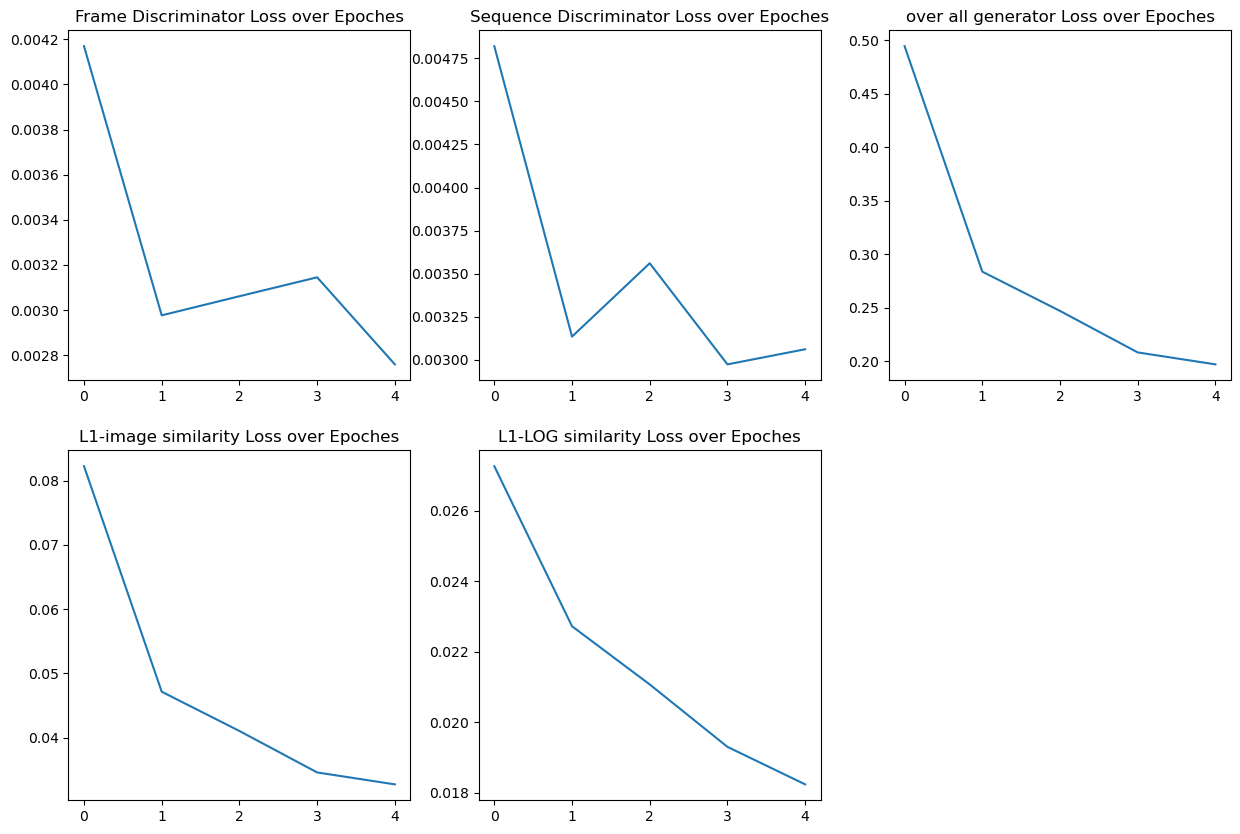

In [16]:
fig = plt.figure(1, figsize=(15,10))

plt.subplot(2,3,1)
plt.plot(loss_frame_discriminator_over_epochs)
plt.title('Frame Discriminator Loss over Epoches')

plt.subplot(2,3,2)
plt.plot(loss_sequence_discriminator_over_epochs)
plt.title('Sequence Discriminator Loss over Epoches')

plt.subplot(2,3,3)
plt.plot(loss_generator_over_epochs)
plt.title('over all generator Loss over Epoches')

plt.subplot(2,3,4)
plt.plot(loss_generator_similarity_over_epochs)
plt.title('L1-image similarity Loss over Epoches')

plt.subplot(2,3,5)
plt.plot(loss_generator_LOG_similarity_over_epochs)
plt.title('L1-LOG similarity Loss over Epoches')
plt.show()

# Prediction

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

import numpy as np
import matplotlib.pyplot as plt
import cv2
import math

import glob
import pickle as pkl
import import_ipynb

from IPython.display import HTML
from base64 import b64encode



Loading trained model

In [22]:
model_path = "D:/GIKI/GEN AI/Assignment 3/UCF101/trained_models/Generator4.pth"
test_generator = Generator(12).to(device)
test_generator.load_state_dict(torch.load(model_path))
print('model loaded')

model loaded


C:\Users\Pc\AppData\Local\Temp\ipykernel_8472\1639579706.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_generator.load_state_dict(torch.load(model_path))


In [23]:
def make_prediction(model, index, dataset):

  sample = dataset[index]
  model_input = sample[0:12,:,:]
  model_input = torch.tensor(model_input).to(device)
  target = sample[12:15,:,:]

  predicted = model(model_input)


  cols = 6
  figure, ax = plt.subplots(nrows=1, ncols=cols, figsize=(20, 12))
  model_input = model_input.cpu().numpy()
  target = target.cpu().numpy()
  predicted = predicted.cpu().detach().numpy()

  for col in range(cols):
    if col == 5:
      target = target.transpose(1,2,0)
      target = (target+1) * 127.5
      target = target.astype('uint8')
      ax[col].imshow(target)
      ax[col].set_title(f'Ground Truth Image')

    elif col == 4 :
      predicted = predicted.transpose(1,2,0)
      predicted = (predicted+1) * 127.5
      predicted = predicted.astype('uint8')
      ax[col].imshow(predicted)
      ax[col].set_title(f'predicted')

    else:

      image = model_input[col*3:(col*3)+3,:,:]
      image = image.transpose(1,2,0)
      image = (image+1) * 127.5
      image = image.astype('uint8')
      ax[col].imshow(image)
      ax[col].set_title(f'image{col}')


C:\Users\Pc\AppData\Local\Temp\ipykernel_8472\1232138399.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model_input = torch.tensor(model_input).to(device)


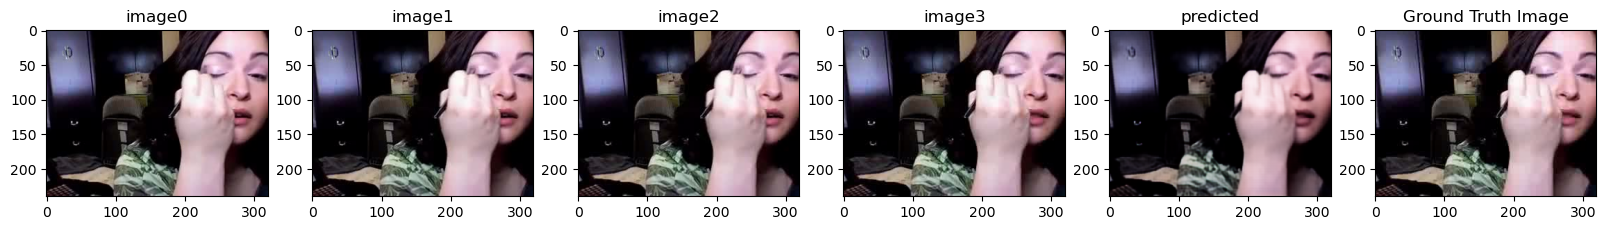

In [24]:
test_dataset = UCF(flag='train')
make_prediction(test_generator,4,test_dataset)

# Saving video both ground truth and predicted

In [26]:
import os
import cv2

output_dir = "D:/GIKI/GEN AI/Assignment 3/UCF101/output_videos"

# Create the directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

ground_truth_video_path = os.path.join(output_dir, 'groundTruth_video.avi')
output_video_path = os.path.join(output_dir, 'output_video.avi')

# Video writer setup for both videos
ground_truth_writer = cv2.VideoWriter(ground_truth_video_path, cv2.VideoWriter_fourcc(*'DIVX'), 4, (320, 240))
output_writer = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'DIVX'), 4, (320, 240))

# Load dataset
test_dataset = UCF(flag='train')
time_step = 100

for i in range(min(time_step, len(test_dataset))):
    target = test_dataset[i][12:15, :, :]
    target = target.numpy()
    target = target.transpose(1, 2, 0)
    target = (target + 1) * 127.5
    target = target.astype('uint8')
    target = cv2.cvtColor(target, cv2.COLOR_RGB2BGR)

    # Write to ground truth video
    ground_truth_writer.write(target)

    # Write to output video
    processed_target = cv2.GaussianBlur(target, (5, 5), 0)
    output_writer.write(processed_target)

# Release video writers
ground_truth_writer.release()
output_writer.release()

# Print the locations of saved videos
print(f"Ground truth video saved at: {ground_truth_video_path}")
print(f"Output video saved at: {output_video_path}")


Ground truth video saved at: D:/GIKI/GEN AI/Assignment 3/UCF101/output_videos\groundTruth_video.avi
Output video saved at: D:/GIKI/GEN AI/Assignment 3/UCF101/output_videos\output_video.avi


# Converting avi to mp4

In [27]:
!ffmpeg -i "D:/GIKI/GEN AI/Assignment 3/UCF101/output_videos/groundTruth_video.avi" "D:/GIKI/GEN AI/Assignment 3/UCF101/output_videos/groundTruth_video.mp4"


ffmpeg version 7.1 Copyright (c) 2000-2024 the FFmpeg developers
  built with clang version 19.1.7
  configuration: --prefix=/d/bld/ffmpeg_1740542337969/_h_env/Library --cc=clang.exe --cxx=clang++.exe --nm=llvm-nm --ar=llvm-ar --disable-doc --enable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libharfbuzz --enable-libfontconfig --enable-libopenh264 --enable-libdav1d --ld=lld-link --target-os=win64 --enable-cross-compile --toolchain=msvc --host-cc=clang.exe --extra-libs=ucrt.lib --extra-libs=vcruntime.lib --extra-libs=oldnames.lib --strip=llvm-strip --disable-stripping --host-extralibs= --disable-libopenvino --enable-gpl --enable-libx264 --enable-libx265 --enable-libaom --enable-libsvtav1 --enable-libxml2 --enable-pic --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libvorbis --enable-libopus --enable-librsvg --enable-ffplay --pkg-config=/d/bld/ffmpeg_1740542337969/_build_env/Library/bin/pkg-config
  libavutil      59. 39

In [28]:
import base64
from IPython.display import HTML

# Open the MP4 file in binary mode
mp42 = open("D:/GIKI/GEN AI/Assignment 3/UCF101/output_videos/groundTruth_video.mp4", "rb").read()

# Encode the binary content to Base64
data_url = "data:video/mp4;base64," + base64.b64encode(mp42).decode()

# Display the video in Jupyter Notebook
HTML(f"""
<video width=320 height=240 controls>
      <source src="{data_url}" type="video/mp4">
</video>
""")


# Converting Output video to mp4

In [29]:
!ffmpeg -i "D:/GIKI/GEN AI/Assignment 3/UCF101/output_videos/output_video.avi" "D:/GIKI/GEN AI/Assignment 3/UCF101/output_videos/output_video.mp4"

ffmpeg version 7.1 Copyright (c) 2000-2024 the FFmpeg developers
  built with clang version 19.1.7
  configuration: --prefix=/d/bld/ffmpeg_1740542337969/_h_env/Library --cc=clang.exe --cxx=clang++.exe --nm=llvm-nm --ar=llvm-ar --disable-doc --enable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libharfbuzz --enable-libfontconfig --enable-libopenh264 --enable-libdav1d --ld=lld-link --target-os=win64 --enable-cross-compile --toolchain=msvc --host-cc=clang.exe --extra-libs=ucrt.lib --extra-libs=vcruntime.lib --extra-libs=oldnames.lib --strip=llvm-strip --disable-stripping --host-extralibs= --disable-libopenvino --enable-gpl --enable-libx264 --enable-libx265 --enable-libaom --enable-libsvtav1 --enable-libxml2 --enable-pic --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libvorbis --enable-libopus --enable-librsvg --enable-ffplay --pkg-config=/d/bld/ffmpeg_1740542337969/_build_env/Library/bin/pkg-config
  libavutil      59. 39

In [30]:
import base64
from IPython.display import HTML

# Open the MP4 file in binary mode
mp42 = open("D:/GIKI/GEN AI/Assignment 3/UCF101/output_videos/output_video.mp4", "rb").read()

# Encode the binary content to Base64
data_url = "data:video/mp4;base64," + base64.b64encode(mp42).decode()

# Display the video in Jupyter Notebook
HTML(f"""
<video width=320 height=240 controls>
      <source src="{data_url}" type="video/mp4">
</video>
""")


In [31]:
test_dataset = UCF(flag='train')

# Calculating PSNR

In [32]:
psnr = 0
for sample in test_dataset:

  model_input = sample[0:12,:,:]
  model_input = torch.tensor(model_input).to(device)

  target = sample[12:15,:,:]
  predicted = test_generator(model_input)

  target = target.numpy()
  target = target.transpose(1,2,0)
  target = (target+1) * 127.5
  target = target.astype('uint8')

  predicted = predicted.detach().cpu().numpy()
  predicted = predicted.transpose(1,2,0)
  predicted = (predicted+1) * 127.5
  predicted = predicted.astype('uint8')

  MSE = np.mean((target - predicted) ** 2)
  if MSE == 0:
    psnr += 100
  else:
    psnr += (20 * math.log10(255/math.sqrt(MSE)))

print('PSNR= ',psnr/len(test_dataset))

C:\Users\Pc\AppData\Local\Temp\ipykernel_8472\2607585330.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model_input = torch.tensor(model_input).to(device)


PSNR=  31.31074340081103
